In [1]:
import numpy as np
import matplotlib
import sys
import cv2

import math

def mask_for_dot(coords, n, img):
    j, i = map(int, coords)
    bord1, bord2 = img.shape
    a1 = max(i-n, 0)
    b1 = min(i+n+1, bord1-1)
    a2 = max(j-n, 0)
    b2 = min(j+n+1, bord2-1)
    
    return img[a1:b1, a2:b2]

def mask_map(coords, n, img):
    res = np.zeros(len(coords))
    for i in range(len(coords)):
        res[i] = np.mean(mask_for_dot(coords[i], n, img))
    return res

def rotate_vector(vector, point, radians):
    """
    Rotate a 2D vector around a point by a specified angle in radians.
    
    Args:
    vector (tuple): A tuple (x, y) representing the vector to rotate.
    point (tuple): A tuple (px, py) representing the point to rotate around.
    radians (float): The angle in radians by which to rotate the vector.
    
    Returns:
    tuple: The rotated vector (x', y').
    """
    x, y = vector
    px, py = point
    
    # Translate the vector so the point of rotation is at the origin
    translated_x = x - px
    translated_y = y - py
    
    # Perform the rotation using the 2D rotation matrix
    cos_theta = math.cos(radians)
    sin_theta = math.sin(radians)
    
    rotated_x = translated_x * cos_theta - translated_y * sin_theta
    rotated_y = translated_x * sin_theta + translated_y * cos_theta
    
    # Translate the vector back to its original position
    rotated_x += px
    rotated_y += py
    
    return rotated_x, rotated_y

def drawPts():
    global src, pts, piv, im
    im = src.copy()

    col = pts[:, 2] - pts[:, 3] + 1
    for i in range(len(pts)):
        cv2.circle(im, np.int32(pts[i][:2]), 3, (0, 0, 255) if (col[i] == 0) else (0, 255, 0) , -1)
    # cv2.circle(im, piv, 3, (255, 255, 0), -1)
    
def addPivot(event, x, y, flags, param):
    global src, piv
    if event == cv2.EVENT_LBUTTONDOWN:
        piv = (x,y)
        drawPts() 

def readSrc(srcName):
    src = cv2.imread(srcName)
    # old_points = np.float32([[ 45. , 53.], [802.  ,44.], [ 64. ,819.], [819. ,820.]])
    # new_points = np.float32( [[ 45.,  44.], [819. , 44.], [ 45., 820.], [819., 820.]])
 
    # M = cv2.getPerspectiveTransform(old_points, new_points)
    # im = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    # src = cv2.warpPerspective(src, M, (1000,1000), borderValue=125)
    # src = src[::-1]
    return src

def updateGap(place, val):
    global pts, gap
    pts[:, :2] -= gap[:2] 
    pts[:, :2] /= gap[2:]
    gap[place] += val
    pts[:, :2] *= gap[2:]
    pts[:, :2] += gap[:2]
    drawPts()

def rotatePts(a):
    global rot
    #pts[:, :2] -= gap[:2]
    #pts[:, :2] /= gap[2:]
    pts[:, 0], pts[:, 1] = rotate_vector((pts[:, 0], pts[:, 1]), (0, 0), np.radians(a))
    pts[:, 2], pts[:, 3] = rotate_vector((pts[:, 2], pts[:, 3]), (0, 0), np.radians(a))
    rot += a
    #pts[:, :2] *= gap[2:]
    #pts[:, :2] += gap[:2]
    drawPts()

def saveToTxt(lattice_name):
    global pts
    np.savetxt("cutted_" + lattice_name, pts)

In [52]:
piv = [500, 500]
src = np.loadtxt("data/260K/40.txt") / 255
lattice_name = "allepo_N5400.txt"
pts = np.loadtxt(lattice_name)
rot =  44.4
pts[:, 0], pts[:, 1] = rotate_vector((pts[:, 0], pts[:, 1]), (0, 0), np.radians(rot))
pts[:, 2], pts[:, 3] = rotate_vector((pts[:, 2], pts[:, 3]), (0, 0), np.radians(rot))
gap = np.array([383., -720., 29.8, 29.3])
pts[:, :2] *= gap[2:]
pts[:, :2] += gap[:2]

delited_pts = np.array([-1, -1, -1, -1], ndmin=2)
drawPts()


wintitle = "select points. (q) - quit, (d) - delite point , (r) - return point, (s) - save to file, f - revert color"
cv2.namedWindow(wintitle, cv2.WINDOW_KEEPRATIO | cv2.WINDOW_GUI_EXPANDED | cv2.WINDOW_NORMAL)

while(1):
    cv2.imshow(wintitle, im)

    k = cv2.waitKey(50) & 0xFF
    if k == ord('a'): updateGap(0, -1)
    elif k == ord('d'): updateGap(0, 1)
    elif k == ord('w'): updateGap(1, -1)
    elif k == ord('s'): updateGap(1, 1)
    elif k == ord('z'): updateGap(2, -0.1)
    elif k == ord('x'): updateGap(2, 0.1)
    elif k == ord('c'): updateGap(3, -0.1)
    elif k == ord('v'): updateGap(3, 0.1) 
    elif k == ord('e'): rotatePts(0.1) 
    elif k == ord('q'): rotatePts(-0.1)
    elif k == ord('p'): print(gap, rot)

    if not cv2.getWindowProperty(wintitle, cv2.WND_PROP_VISIBLE):
        break

cv2.destroyAllWindows()

#[-863.    56.    28.    27.1] -14.3

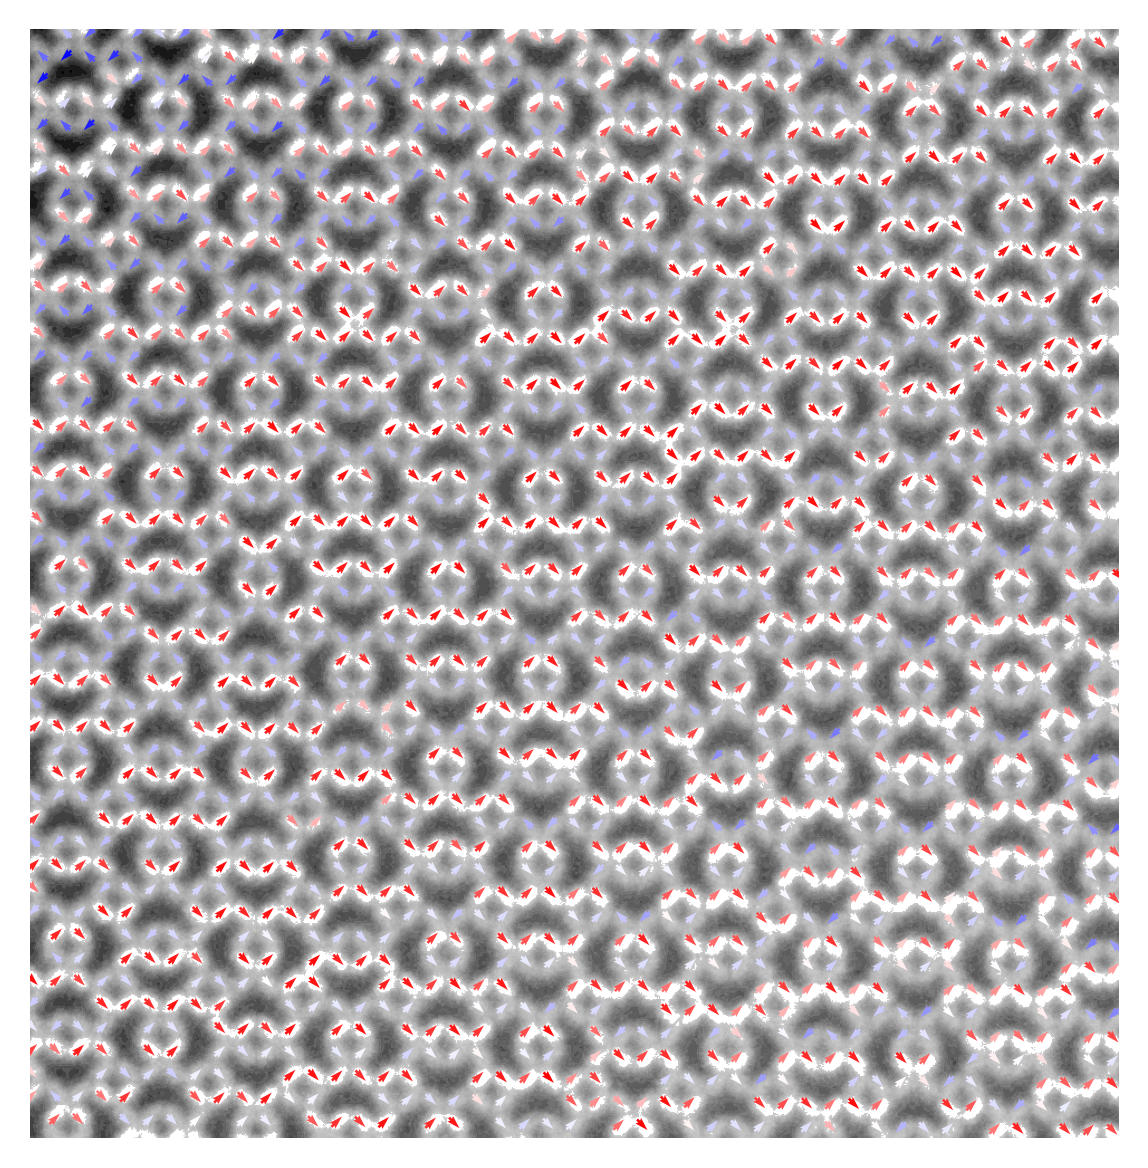

In [53]:
import matplotlib.pyplot as plt
if src.shape[-1] == 3:
    src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
plt.figure(dpi=300)
plt.axis('off')
plt.imshow(src, cmap='gray')
plt.xlim(0, src.shape[1])
plt.ylim(0, src.shape[0])
pts = pts[(pts[:, 0] > 0) & (pts[:, 0] < src.shape[1]) & (pts[:, 1] > 0) & (pts[:, 1] < src.shape[0])]

norm_mask = (mask_map(pts[:, :2], 5, src) - mask_map(pts[:, :2], 10, src).min()) / (mask_map(pts[:, :2], 5, src) - mask_map(pts[:, :2], 10, src).min()).max() * 255

pts[np.dot(pts[:, 2:], np.array([1, 0])) < 0, 2:] *= -1
pts[norm_mask < 117, 2:4] *= -1
#скалярное произведение с направлением XMCD > 0 значит черное (или наоборот) 

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue", "white", "red"])
plt.quiver(pts[:, 0], pts[:, 1], pts[:, 2], pts[:, 3], norm_mask, pivot='mid', cmap=cmap)

In [21]:
#np.savetxt('XMCD_006.txt', pts, header=f'dx={gap[0]} dy={gap[1]} mult_x={gap[2]} mult_y={gap[3]} rot={rot}')

array([[ 2.68938035e+01,  9.81424747e+02,  1.78618170e-03,
        -1.74915835e-03],
       [ 9.27747977e+00,  5.38723361e+02, -1.74915835e-03,
        -1.78618170e-03],
       [ 4.04519667e+01,  5.38252853e+02, -1.78618170e-03,
         1.74915835e-03],
       ...,
       [ 9.54499789e+02,  1.56711328e+02,  2.42145790e-03,
        -6.21724718e-04],
       [ 9.39332046e+02,  1.83170346e+02,  6.21724718e-04,
         2.42145790e-03],
       [ 9.28085178e+02,  1.40622705e+02,  6.21724718e-04,
         2.42145790e-03]])

In [55]:
T = 260
for i in range(75):
    file = f"data/{T}K/{i}.txt"
    src = np.loadtxt(file) / 255
    if src.shape[-1] == 3:
        src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        
    pts = pts[(pts[:, 0] > 0) & (pts[:, 0] < src.shape[1]) & (pts[:, 1] > 0) & (pts[:, 1] < src.shape[0])]

    norm_mask = (mask_map(pts[:, :2], 6, src) - mask_map(pts[:, :2], 8, src).min()) / (mask_map(pts[:, :2], 6, src) - mask_map(pts[:, :2], 8, src).min()).max() * 255

    pts[np.dot(pts[:, 2:], np.array([1, 0])) < 0, 2:] *= -1
    pts[norm_mask < 117, 2:4] *= -1
    
    dst = f"data/{T}K/XMCD_" + "%03d.txt" % i
    np.savetxt(dst, pts, header=f'dx={gap[0]} dy={gap[1]} mult_x={gap[2]} mult_y={gap[3]} rot={rot}')
    acc = ((norm_mask < 117).sum() / norm_mask.size)
    #assert  acc < 0.7 and acc > 0.3, f"Too low accuracy in {file}: acc is {acc}"
    acc = (np.abs(norm_mask - 117) < 20).sum()
    #assert  acc < norm_mask.size // 5, f"Too low accuracy in {file}: there is {acc} wrong particles"